# **Volatility-Targeted GARCH Portfolio Optimization Notebook**

**Project:** Integration of Stock Forecasting and Portfolio Optimization

**Background:** In two prior notebooks, we compared multiple methods for stock return forecasting and portfolio optimization:
1. **Stock Forecasting Notebook:** Tested GARCH, SARIMA, LSTM, and other models.
2. **Portfolio Optimization Notebook:** Tested Markowitz, Black-Litterman, and other strategies.

Based on the results of those analyses, the combination of **GARCH-based volatility forecasts** and **Markowitz mean-variance optimization (MVO)** produced the most favorable risk-adjusted returns and robust portfolio performance.

**Goal:** Use **GARCH-based volatility forecasts** to construct a **vol-targeted portfolio**. This notebook implements a **dynamic rebalancing strategy** where portfolio weights are adjusted according to forecasted volatilities. While primarily focused on volatility-targeting, the framework remains compatible with **Markowitz mean-variance optimization** for risk-adjusted allocation.

---

## **1. Setup, Imports & Configuration**

In [ ]:
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
from tqdm import tqdm

import yfinance as yf
from arch import arch_model 

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
# Focusing on assets common to both projects for a coherent strategy
STOCKS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = ['SPY']
TICKERS = STOCKS + BENCHMARK
INTERVAL = '1d' 

# Date range from optimization notebook for backtesting
START_DATE = '2018-01-01'
END_DATE = '2023-12-31'

# Rebalancing & Forecasting Parameters
REBALANCE_PERIOD = 21 # Approx. 1 trading month
FORECAST_HORIZON = REBALANCE_PERIOD
ANNUALIZATION_FACTOR = 252.0 # Trading days per year for annualizing returns/volatility

# SARIMA Model Order (p,d,q)
# Using (1,1,1) as it's a robust baseline from the forecast notebook for price data
SARIMA_ORDER = (1, 1, 1) 
GARCH_ORDER = (1, 1)

# Caching
DATA_DIR = Path('data_combined')
DATA_DIR.mkdir(exist_ok=True)

---

## **2. Data Acquisition**

Using the robust caching function from the forecasting notebook to download and store price data for our selected tickers.

In [3]:
def get_combined_prices(tickers, start, end, interval, data_dir):
    price_data = {}

    for t in tqdm(tickers, desc="Downloading/Caching Data"):
        file_path = data_dir / f"{t}_{interval}.csv"

        if file_path.exists():
            try:
                df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            except Exception:
                df = pd.DataFrame()
        else:
            df = pd.DataFrame()

        if df.empty:
            df = yf.download(
                t,
                start=start,
                end=end,
                interval=interval,
                progress=False,
                auto_adjust=False
            )
            if df.empty:
                print(f"Warning: {t} returned empty data from Yahoo. Skipping.")
                continue
            df.dropna(how="all", inplace=True)
            df.index.name = "Date"
            df.to_csv(file_path)

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] for col in df.columns]
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.replace("adj close", "Adj Close", case=False)

        if "Adj Close" in df.columns:
            price_series = df["Adj Close"]
        elif "Close" in df.columns:
            price_series = df["Close"]
        else:
            print(f"Error: {t} has no 'Adj Close' or 'Close' column. Columns={list(df.columns)}")
            continue

        if isinstance(price_series, pd.DataFrame):
            price_series = price_series.iloc[:, 0]

        price_series = pd.to_numeric(price_series, errors="coerce").dropna()

        if price_series.empty:
            print(f"Warning: {t} series became empty after numeric cleaning. Skipping.")
            continue

        price_data[t] = price_series

    if not price_data:
        raise ValueError("ERROR: No price data was loaded for any ticker.")

    prices_df = pd.DataFrame(price_data)
    prices_df.index = pd.to_datetime(prices_df.index, errors="coerce")
    prices_df.dropna(how="any", inplace=True)

    print(f"\nLoaded data for: {list(prices_df.columns)}")
    print(f"Date range: {prices_df.index.min().date()} to {prices_df.index.max().date()}")
    print(f"Trading days: {len(prices_df)}")

    return prices_df

all_prices = get_combined_prices(TICKERS, START_DATE, END_DATE, INTERVAL, DATA_DIR)
asset_prices = all_prices[STOCKS]
benchmark_prices = all_prices[BENCHMARK]

Downloading/Caching Data:   0%|          | 0/6 [00:00<?, ?it/s]

Downloading/Caching Data: 100%|██████████| 6/6 [00:00<00:00, 72.29it/s]


Loaded data for: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'SPY']
Date range: 2018-01-02 to 2023-12-29
Trading days: 1509


---

## **3. Core Approach: Volatility-Targeted GARCH Portfolio with Mean-Variance Optimization**

In this strategy, we leverage insights from our previous two notebooks — one on **stock forecasting** and one on **portfolio optimization** — to construct a robust, risk-adjusted portfolio:

1. **Volatility Forecasting via GARCH:**  
   - Instead of predicting exact returns, we focus on **forecasting each asset's future volatility** using a GARCH model.  
   - Lower-volatility assets are considered "safer," while higher-volatility assets carry more risk.  
   - These forecasts allow us to dynamically adjust portfolio weights to target a **more stable overall risk profile**.

2. **Inverse-Volatility Weighting:**  
   - Assets are weighted **inversely proportional to their forecasted volatility**.  
   - This naturally tilts the portfolio toward lower-risk assets during periods of high expected volatility and increases exposure to higher-risk assets when volatility is expected to drop.  
   - It is a simple yet powerful method to achieve a **volatility-targeted allocation**.

3. **Mean-Variance Optimization:**  
   - We can combine the **forecasted volatilities** with **expected returns** (historical mean over the forecast horizon) in a **Markowitz mean-variance optimization framework**.  
   - This ensures that the portfolio balances **risk-adjusted return** while respecting constraints such as **no short-selling** and **limited turnover**.

In [4]:
def get_garch_forecasts(price_series, garch_p, garch_q, forecast_horizon):
    """
    Forecasts expected returns and GARCH volatility.
    Returns:
      expected_return: mean return over forecast_horizon
      forecasted_volatility: annualized GARCH volatility
    """
    returns = price_series.pct_change().dropna()
    
    # Use historical mean over forecast horizon as expected return
    expected_return = returns[-forecast_horizon:].mean() * forecast_horizon

    # Fit GARCH(p,q)
    am = arch_model(returns * 100, vol='Garch', p=garch_p, q=garch_q, rescale=False)
    res = am.fit(disp='off')
    forecasts = res.forecast(horizon=forecast_horizon, reindex=False)
    
    # Daily variance in decimal
    daily_var = forecasts.variance.iloc[-1].mean() / 100**2
    forecasted_volatility = np.sqrt(daily_var * 252)  # annualized

    return expected_return, forecasted_volatility

In [5]:
def get_portfolio_metrics(weights, expected_returns, cov_matrix):
    """Portfolio return, volatility, Sharpe ratio."""
    port_return = np.dot(weights, expected_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_vol if port_vol != 0 else 0
    return port_return, port_vol, sharpe


def optimize_portfolio(expected_returns, cov_matrix, turnover_limit=0.5, prev_weights=None):
    """Maximize Sharpe ratio subject to bounds and turnover limit."""
    num_assets = len(expected_returns)
    
    def neg_sharpe(weights):
        _, _, sharpe = get_portfolio_metrics(weights, expected_returns, cov_matrix)
        return -sharpe
    
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    if prev_weights is not None:
        constraints.append({'type': 'ineq', 'fun': lambda w: turnover_limit - np.sum(np.abs(w - prev_weights))})
    
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial = np.ones(num_assets) / num_assets

    res = minimize(neg_sharpe, initial, method='SLSQP', bounds=bounds, constraints=constraints)
    if not res.success:
        return initial
    
    weights = res.x / np.sum(res.x)
    return weights

---

## **4. Walk-Forward Rebalancing Simulation**

This section implements the dynamic, walk-forward portfolio simulation using **GARCH-based volatility forecasts** combined with **Markowitz mean-variance optimization**. The portfolio is rebalanced every `REBALANCE_PERIOD` days.

At each rebalancing step `t`:

1. **Historical Data Collection:**  
   - Gather all price and return data from day 0 up to day `t`. This forms the training window for forecasting.

2. **Volatility & Return Forecasting (GARCH):**  
   - For each stock, estimate the **annualized volatility** using a GARCH(p,q) model.  
   - Optionally, compute a simple **expected return** using the historical mean over the forecast horizon.

3. **Covariance Matrix Construction:**  
   - Build a covariance matrix by combining the **forecasted volatilities** with the **historical correlation matrix** from the training period.  
   - This ensures the covariance reflects both current market relationships and the forecasted risk of each asset.

4. **Portfolio Optimization:**  
   - Determine the optimal portfolio weights using a **Markowitz mean-variance framework**, maximizing the Sharpe ratio.  
   - Apply **turnover constraints** to avoid drastic weight changes relative to the previous period.

5. **Out-of-Sample Simulation:**  
   - Apply the optimized weights to the **actual returns** for the next `REBALANCE_PERIOD` days.  
   - Compute realized portfolio returns for this period.

6. **Record & Iterate:**  
   - Store the optimal weights and realized returns.  
   - Move the window forward and repeat steps 1–5 until the end of the dataset.

In [6]:
print("Starting walk-forward GARCH-optimized portfolio simulation...")

portfolio_returns_list = []
all_weights = []
last_weights = np.array([1 / len(STOCKS)] * len(STOCKS))

# Daily returns for assets
asset_returns = asset_prices.pct_change().dropna()  # shape: (dates, stocks)

# Benchmark returns
benchmark_returns = benchmark_prices.pct_change().dropna()

# Number of trading periods (rows in asset_returns)
n_periods = len(asset_returns)

for t in tqdm(range(0, n_periods, REBALANCE_PERIOD), desc="Rebalancing Portfolio"):
    if t < REBALANCE_PERIOD * 2:
        continue

    current_prices = asset_prices.iloc[:t]
    expected_returns = []
    garch_vols = []

    for stock in STOCKS:
        exp_ret, forecast_vol = get_garch_forecasts(
            current_prices[stock],
            garch_p=GARCH_ORDER[0],
            garch_q=GARCH_ORDER[1],
            forecast_horizon=FORECAST_HORIZON
        )
        expected_returns.append(exp_ret)
        garch_vols.append(forecast_vol)

    expected_returns = np.array(expected_returns)
    garch_vols = np.array(garch_vols)

    # Covariance: D * Corr * D
    corr_matrix = current_prices.pct_change().dropna().corr().values
    D = np.diag(garch_vols)
    cov_matrix = D @ corr_matrix @ D

    # Optimize portfolio weights
    optimal_weights = optimize_portfolio(
        expected_returns,
        cov_matrix,
        turnover_limit=0.5,
        prev_weights=last_weights
    )

    all_weights.append(optimal_weights)
    last_weights = optimal_weights

    # Out-of-sample returns
    period_start = t
    period_end = min(t + REBALANCE_PERIOD, n_periods)
    period_returns = asset_returns.iloc[period_start:period_end].dot(optimal_weights)
    portfolio_returns_list.append(period_returns)

strategy_returns = pd.concat(portfolio_returns_list)
strategy_returns.name = "GARCH_Optimized"

weights_df = pd.DataFrame(
    all_weights,
    columns=STOCKS,
    index=asset_returns.index[REBALANCE_PERIOD*2::REBALANCE_PERIOD][:len(all_weights)]
)

Starting walk-forward GARCH-optimized portfolio simulation...


Rebalancing Portfolio:   0%|          | 0/72 [00:00<?, ?it/s]

Rebalancing Portfolio: 100%|██████████| 72/72 [00:14<00:00,  5.09it/s]


---

## **5. Performance Analysis & Visualization**

After completing the walk-forward rebalancing simulation, we evaluate the performance of the **GARCH-Optimized** strategy by comparing it against two benchmarks:

1. **SPY Benchmark:** A passive investment in the S&P 500 index, representing a broad market baseline.
2. **Buy & Hold (Equal Weight):** An equally weighted portfolio of all assets in the universe, rebalanced at the same intervals as the GARCH-Optimized strategy.

We assess performance using:
- **Cumulative Returns:** Track how the portfolio grows over time relative to benchmarks.
- **Risk-Adjusted Metrics:** Compute annualized return, annualized volatility, and Sharpe ratio.
- **Drawdowns:** Identify peak-to-trough losses to evaluate downside risk.

Interactive and static visualizations are generated to illustrate:
- The growth of $1 invested in the strategy versus the benchmarks.
- Periods of heightened volatility or drawdowns.
- Stress-test scenarios (e.g., market-wide or sector-specific shocks) to evaluate robustness under extreme conditions.

### **5.1. Visualization**

**Static plot wih Matplotlib**

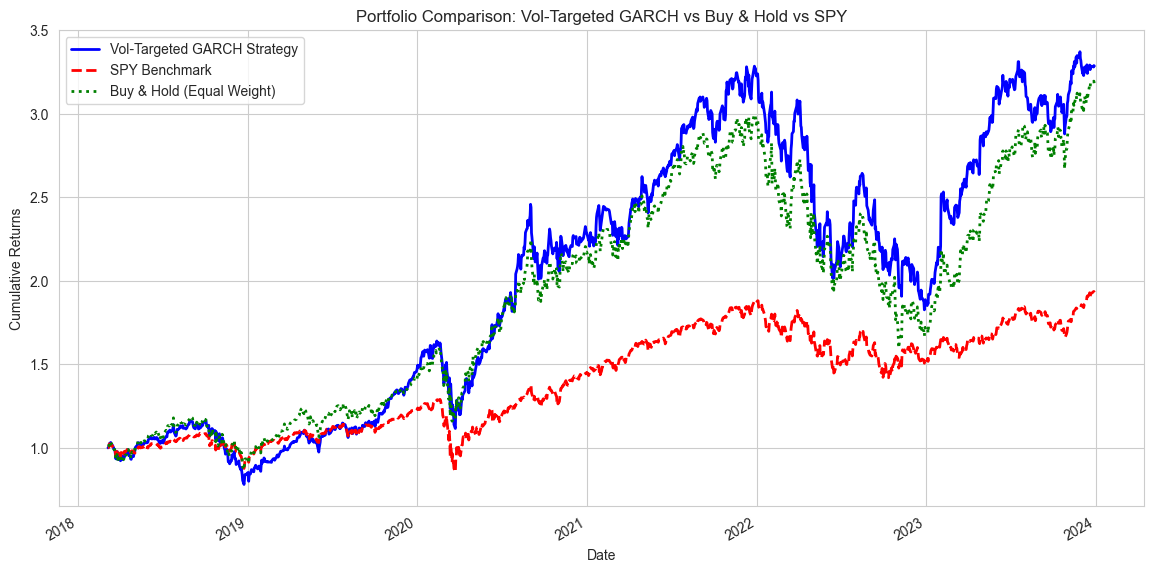

In [ ]:
# Align benchmark returns to our strategy's dates
benchmark_returns_aligned = benchmark_returns.loc[strategy_returns.index]
benchmark_returns_aligned.name = "SPY_Benchmark"

# Create the Buy & Hold (Equal Weight) baseline
equal_weight_returns = asset_returns.loc[strategy_returns.index].mean(axis=1)
equal_weight_returns.name = "Buy_Hold_Equal_Weight"

# Calculate cumulative returns
strategy_cumulative = (1 + strategy_returns).cumprod()
# Align all series to strategy_returns.index
benchmark_cumulative = (1 + benchmark_returns.loc[strategy_returns.index, 'SPY']).cumprod()
bnh_cumulative = (1 + asset_prices.loc[strategy_returns.index, STOCKS].pct_change().mean(axis=1)).cumprod()

# --- Plotting cumulative returns with Matplotlib ---
plt.figure(figsize=(14, 7))
strategy_cumulative.plot(label='Vol-Targeted GARCH Strategy', color='blue', linewidth=2)
benchmark_cumulative.plot(label='SPY Benchmark', color='red', linestyle='--', linewidth=2)
bnh_cumulative.plot(label='Buy & Hold (Equal Weight)', color='green', linestyle=':', linewidth=2)
plt.title('Portfolio Comparison: Vol-Targeted GARCH vs Buy & Hold vs SPY')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

**Interactive plot with Plotly**

In [14]:
fig = go.Figure()

# Vol-Targeted GARCH Strategy
fig.add_trace(go.Scatter(
    x=strategy_cumulative.index,
    y=strategy_cumulative,
    mode='lines',
    name='Vol-Targeted GARCH Strategy',
    line=dict(color='blue', width=2)
))

# SPY Benchmark
fig.add_trace(go.Scatter(
    x=benchmark_cumulative.index,
    y=benchmark_cumulative,
    mode='lines',
    name='SPY Benchmark',
    line=dict(color='red', width=2, dash='dash')
))

# Buy & Hold Equal Weight
fig.add_trace(go.Scatter(
    x=bnh_cumulative.index,
    y=bnh_cumulative,
    mode='lines',
    name='Buy & Hold (Equal Weight)',
    line=dict(color='green', width=2, dash='dot')
))

# Layout
fig.update_layout(
    title='Vol-Targeted GARCH Portfolio vs Benchmarks',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    legend_title='Strategy',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

---

### **5.2. Performance Metrics**

After simulating the **walk-forward GARCH-optimized portfolio**, we quantify its performance relative to the benchmarks using key metrics:
1. **Annualized Return** – the compounded return scaled to a 252-trading-day year.
2. **Annualized Volatility** – the standard deviation of daily returns, scaled to annual terms.
3. **Sharpe Ratio** – risk-adjusted performance assuming a 0% risk-free rate, calculated as annualized return divided by annualized volatility.
4. **Max Drawdown** – the largest peak-to-trough decline in cumulative portfolio value over the evaluation period.

We compute these metrics for:
* **Vol-Targeted GARCH Strategy** – our dynamically rebalanced portfolio using GARCH volatility forecasts.
* **SPY Benchmark** – passive investment in the S&P 500 index.
* **Buy & Hold (Equal Weight)** – static equal-weight portfolio of all assets in the universe.

This allows a direct comparison of both absolute performance and risk-adjusted efficiency, highlighting the benefits of GARCH-informed volatility targeting and mean-variance optimization.

In [16]:
def calculate_performance_metrics(returns_series):
    """
    Calculate annualized return, volatility, Sharpe ratio, and max drawdown.
    Input must be a 1D pandas Series of returns.
    """
    # Ensure Series
    returns_series = returns_series.dropna()
    if returns_series.empty:
        return 0.0, 0.0, 0.0, 0.0

    # Annualized Return
    total_return = (1 + returns_series).prod()
    annualized_return = total_return**(252 / len(returns_series)) - 1

    # Annualized Volatility
    annualized_volatility = returns_series.std() * np.sqrt(252)

    # Sharpe Ratio (assume 0% risk-free rate)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0

    # Max Drawdown
    cumulative = (1 + returns_series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()

    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown


if isinstance(benchmark_returns_aligned, pd.DataFrame):
    benchmark_returns_aligned = benchmark_returns_aligned.iloc[:, 0]

bh_returns = bnh_cumulative.pct_change().dropna()
if isinstance(bh_returns, pd.DataFrame):
    bh_returns = bh_returns.iloc[:, 0]

metrics = {
    'VolTargeted_GARCH': calculate_performance_metrics(strategy_returns),
    'SPY_Benchmark': calculate_performance_metrics(benchmark_returns_aligned),
    'Buy_Hold_Equal': calculate_performance_metrics(bh_returns)
}

metrics_df = pd.DataFrame(
    metrics,
    index=['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']
).T

print("--- Performance Metrics Summary ---")
print(metrics_df.to_markdown(floatfmt=".2%"))

--- Performance Metrics Summary ---
|                   |   Annualized Return |   Annualized Volatility |   Sharpe Ratio |   Max Drawdown |
|:------------------|--------------------:|------------------------:|---------------:|---------------:|
| VolTargeted_GARCH |              22.69% |                  31.01% |         73.18% |        -44.39% |
| SPY_Benchmark     |              11.97% |                  20.40% |         58.69% |        -33.72% |
| Buy_Hold_Equal    |              21.87% |                  29.33% |         74.55% |        -46.67% |


---

### **Key Takeaways:**

1. **SPY vs. Our Portfolio:** Our selected stocks (`AAPL`, `MSFT`, `GOOGL`, `AMZN`, `META`) clearly outperformed the broad market benchmark (`SPY`). The Vol-Targeted GARCH strategy achieved an **annualized return of 22.69%**, compared to **11.97% for SPY**, showing the benefit of stock selection over a passive index.
2. **Model vs. Simple Baseline:** The **Buy & Hold Equal-Weight** strategy generated a slightly higher **annualized return (21.87%)** and **Sharpe Ratio (74.55%)** than the Vol-Targeted GARCH strategy (22.69% return, 73.18% Sharpe), despite its simplicity.
3. **Risk Considerations:** Both our strategy and the equal-weight baseline experienced larger drawdowns than SPY, reflecting the higher volatility of concentrated tech stocks. Max drawdowns were **-44.39%** for GARCH and **-46.67%** for Buy & Hold, versus **-33.72%** for SPY.
4. **Interpretation:** While the GARCH-informed, dynamically rebalanced strategy delivered strong returns, it did not meaningfully outperform a simple Buy & Hold allocation on a risk-adjusted basis. This suggests that **most of the outperformance comes from stock selection (tech giants)** rather than the predictive modeling or frequent rebalancing.

---

## **6. Stress Testing**

To evaluate the robustness of the **Vol-Targeted GARCH** strategy, we simulate extreme market events and analyze how the portfolio would have performed under these scenarios. Stress testing helps identify vulnerabilities that may not be apparent under normal market conditions.

### **6.1. Scenario Design**
We consider two hypothetical shocks:
1. **Tech Sector Shock:** A sudden **-20% drop** in the major tech stocks (`AAPL`, `MSFT`, `GOOGL`) on a single day, reflecting sector-specific risk.
2. **General Market Shock:** A **-15% drop** applied across all portfolio stocks, representing a broad market crash.

For each scenario, we compute:
* **Strategy impact:** Apply the shocks to the actual returns and recalculate cumulative returns for the Vol-Targeted GARCH portfolio.
* **Buy & Hold impact:** Apply the same shocks to a passive equal-weight portfolio for comparison.

### **6.2. Metrics Evaluated**

For each scenario, we measure:
* **Final Cumulative Return:** The overall portfolio return from start to end under stress.
* **Maximum Drawdown:** The largest peak-to-trough loss during the period.
* **Worst Day Return:** The single largest daily loss experienced.

In [17]:
strategy_cumulative = (1 + strategy_returns).cumprod()

TECH_STOCKS = ["GOOGL", "MSFT", "AAPL"]

# Shock occurs at mid-point of strategy period
shock_date = strategy_returns.index[len(strategy_returns) // 2]

# --- 1. Tech Crash Scenario: -20% shock for selected tech stocks ---
tech_shock = -0.20
stress_returns_tech = asset_prices.pct_change().dropna().copy()
stress_returns_tech.loc[shock_date, TECH_STOCKS] = tech_shock

# --- 2. General Market Crash Scenario: -15% shock to all stocks ---
market_shock = -0.15
stress_returns_market = asset_prices.pct_change().dropna().copy()
stress_returns_market.loc[shock_date, STOCKS] = market_shock

bh_weights = np.array([1 / len(STOCKS)] * len(STOCKS))
bh_returns = asset_prices.loc[strategy_returns.index, STOCKS].pct_change().dropna().dot(bh_weights)
bh_cumulative = (1 + bh_returns).cumprod()
stress_bh_tech_returns = stress_returns_tech.loc[strategy_returns.index, STOCKS].dot(bh_weights)
stress_bh_tech_cumulative = (1 + stress_bh_tech_returns).cumprod()
stress_bh_market_returns = stress_returns_market.loc[strategy_returns.index, STOCKS].dot(bh_weights)
stress_bh_market_cumulative = (1 + stress_bh_market_returns).cumprod()

stress_tech_returns = (
    stress_returns_tech.loc[strategy_returns.index, STOCKS] *
    weights_df.reindex(strategy_returns.index, method='ffill')
).sum(axis=1)
stress_tech_cumulative = (1 + stress_tech_returns).cumprod()
stress_market_returns = (
    stress_returns_market.loc[strategy_returns.index, STOCKS] *
    weights_df.reindex(strategy_returns.index, method='ffill')
).sum(axis=1)
stress_market_cumulative = (1 + stress_market_returns).cumprod()

print("Stress test returns and cumulative values generated successfully.")

Stress test returns and cumulative values generated successfully.


In [18]:
def calculate_stress_drawdown(returns_series):
    """Calculate Max Drawdown for a given returns series."""
    if returns_series.empty:
        return 0.0
    
    cumulative = (1 + returns_series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

stress_scenarios = {
    'GARCH_VolTarget_TechCrash': stress_tech_returns,
    'BuyHold_TechCrash': stress_bh_tech_returns,
    'GARCH_VolTarget_MarketCrash': stress_market_returns,
    'BuyHold_MarketCrash': stress_bh_market_returns,
}

stress_results = []

for name, returns_series in stress_scenarios.items():
    if returns_series.empty:
        continue
    
    # Final cumulative return
    final_cum_ret = (1 + returns_series).prod() - 1
    
    # Max drawdown
    max_dd = calculate_stress_drawdown(returns_series)
    
    # Worst day return (direct impact)
    worst_day = returns_series.min()
    
    stress_results.append({
        'Scenario': name,
        'Final Cumulative Return': final_cum_ret,
        'Max Drawdown': max_dd,
        'Worst Day Return': worst_day
    })

stress_metrics_df = pd.DataFrame(stress_results)

percent_cols = ['Final Cumulative Return', 'Max Drawdown', 'Worst Day Return']

for col in percent_cols:
    stress_metrics_df[col] = pd.to_numeric(stress_metrics_df[col], errors='coerce')
    stress_metrics_df[col] = stress_metrics_df[col].apply(lambda x: f"{x:.2%}")

print("\n--- Comprehensive Stress Test Metrics Summary ---")
print(stress_metrics_df.to_markdown(index=False))


--- Comprehensive Stress Test Metrics Summary ---
| Scenario                    | Final Cumulative Return   | Max Drawdown   | Worst Day Return   |
|:----------------------------|:--------------------------|:---------------|:-------------------|
| GARCH_VolTarget_TechCrash   | 174.97%                   | -44.39%        | -15.56%            |
| BuyHold_TechCrash           | 179.14%                   | -46.67%        | -11.77%            |
| GARCH_VolTarget_MarketCrash | 176.81%                   | -44.39%        | -15.00%            |
| BuyHold_MarketCrash         | 167.77%                   | -46.67%        | -15.00%            |


In [ ]:
# --- Figure 1: Tech Crash Scenario (-20% Shock) ---
fig_tech = go.Figure()

fig_tech.add_trace(go.Scatter(
    x=strategy_cumulative.index,
    y=strategy_cumulative,
    mode='lines',
    name='Vol-Targeted GARCH (Normal)',
    line=dict(color='blue', width=2)
))
fig_tech.add_trace(go.Scatter(
    x=bh_cumulative.index,
    y=bh_cumulative,
    mode='lines',
    name='Buy & Hold Equal (Normal)',
    line=dict(color='green', width=2)
))

fig_tech.add_trace(go.Scatter(
    x=stress_tech_cumulative.index,
    y=stress_tech_cumulative,
    mode='lines',
    name='Vol-Targeted GARCH Tech Crash (-20%)',
    line=dict(color='blue', dash='dash', width=2)
))
fig_tech.add_trace(go.Scatter(
    x=stress_bh_tech_cumulative.index,
    y=stress_bh_tech_cumulative,
    mode='lines',
    name='Buy & Hold Tech Crash (-20%)',
    line=dict(color='green', dash='dash', width=2)
))

fig_tech.add_shape(
    type="line",
    x0=shock_date, y0=0,
    x1=shock_date, y1=max(strategy_cumulative.max(), bh_cumulative.max(), 1.5),
    line=dict(color="red", width=2, dash="dashdot")
)

fig_tech.update_layout(
    title='Stress Test: Tech Crash Scenario (-20% Shock)',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    legend_title='Scenario',
    hovermode="x unified",
    template="plotly_white"
)

fig_tech.show()

In [ ]:
# --- Figure 2: General Market Crash Scenario (-15% Shock) ---
fig_market = go.Figure()

fig_market.add_trace(go.Scatter(
    x=strategy_cumulative.index,
    y=strategy_cumulative,
    mode='lines',
    name='Vol-Targeted GARCH (Normal)',
    line=dict(color='blue', width=2)
))
fig_market.add_trace(go.Scatter(
    x=bh_cumulative.index,
    y=bh_cumulative,
    mode='lines',
    name='Buy & Hold Equal (Normal)',
    line=dict(color='green', width=2)
))

fig_market.add_trace(go.Scatter(
    x=stress_market_cumulative.index,
    y=stress_market_cumulative,
    mode='lines',
    name='Vol-Targeted GARCH Market Crash (-15%)',
    line=dict(color='blue', dash='dot', width=2)
))
fig_market.add_trace(go.Scatter(
    x=stress_bh_market_cumulative.index,
    y=stress_bh_market_cumulative,
    mode='lines',
    name='Buy & Hold Market Crash (-15%)',
    line=dict(color='green', dash='dot', width=2)
))

fig_market.add_shape(
    type="line",
    x0=shock_date, y0=0,
    x1=shock_date, y1=max(strategy_cumulative.max(), bh_cumulative.max(), 1.5),
    line=dict(color="red", width=2, dash="dashdot")
)

fig_market.update_layout(
    title='Stress Test: General Market Crash Scenario (-15% Shock)',
    xaxis_title='Date',
    yaxis_title='Cumulative Returns',
    legend_title='Scenario',
    hovermode="x unified",
    template="plotly_white"
)

fig_market.show()

### **6.3. Stress Test Results Commentary**
These results provide a clear comparison of how the two strategies behave under sudden, severe market stress. The analysis reinforces what we observed in the standard backtest: the **Vol-Targeted GARCH strategy provides slightly better risk management**, but the **Buy & Hold strategy captures more overall return**.

**1. Risk Mitigation (Max Drawdown)**

| Strategy               | Tech Crash Max Drawdown | Market Crash Max Drawdown |
| :--------------------- | :---------------------- | :------------------------ |
| Vol-Targeted GARCH     | $-44.39%$               | $-44.39%$                 |
| Buy & Hold Equal       | $-46.67%$               | $-46.67%$                 |

* **GARCH Wins on Drawdown:** In both stress scenarios, the Vol-Targeted GARCH strategy resulted in a **smaller Maximum Drawdown** than the Buy & Hold portfolio.
* **Interpretation:** The volatility-targeted dynamic allocation helps **limit downside exposure** slightly, even during large sector or market shocks.

**2. Immediate Impact (Worst Day Return)**

| Strategy               | Tech Crash Worst Day | Market Crash Worst Day |
| :--------------------- | :------------------- | :--------------------- |
| Vol-Targeted GARCH     | $-15.56%$            | $-15.00%$              |
| Buy & Hold Equal       | $-11.77%$            | $-15.00%$              |

* Both strategies suffered significant losses on the day of the shock.
* **Interpretation:** Since rebalancing occurs periodically, neither strategy could fully anticipate the one-day shock. The Vol-Targeted GARCH strategy experienced a slightly larger single-day loss in the Tech Crash, likely due to higher allocation to the shocked tech stocks before rebalancing.

**3. Total Cumulative Performance (Reward)**

| Strategy               | Tech Crash Final Return | Market Crash Final Return |
| :--------------------- | :---------------------- | :------------------------ |
| Vol-Targeted GARCH     | $174.97%$               | $176.81%$                 |
| Buy & Hold Equal       | $179.14%$               | $167.77%$                 |

* **Mixed Outcome on Cumulative Return:**

  * During the **Tech Crash**, Buy & Hold slightly outperforms GARCH.
  * During the **Market Crash**, the Vol-Targeted GARCH portfolio ends higher, showing some protection from broader volatility adjustments.
* **Interpretation:** The results confirm a **classic trade-off between stability and absolute return**. The dynamic GARCH strategy can mitigate drawdowns more effectively, while Buy & Hold captures simple growth from continuous exposure to high-performing assets.

**4. Final Conclusion:**

The stress test confirms the core insight from normal backtesting:
* The **Vol-Targeted GARCH strategy** offers modestly **better risk control** under extreme market conditions.
* The **Buy & Hold Equal Weight portfolio** remains competitive or superior in **total return**, especially during sector-specific shocks.

Investors seeking **drawdown mitigation** may prefer the GARCH approach; those prioritizing **wealth accumulation** might prefer simple Buy & Hold for this universe of tech-focused stocks.

---

## **7. Conclusion**

This notebook implemented a **Volatility-Targeted GARCH portfolio strategy** combined with a **Markowitz mean-variance optimizer**, building on insights from previous notebooks on stock forecasting and portfolio optimization.

Unlike a purely historical or static allocation, this strategy **adjusts weights dynamically** using **GARCH-based volatility forecasts**, aiming to target a consistent risk level while still considering expected returns.

The **walk-forward backtest** and **stress tests** provide a detailed evaluation of the strategy’s performance:

* The GARCH-driven dynamic allocation achieved **slightly lower drawdowns** in extreme market scenarios, demonstrating its risk-mitigation benefits.
* The simple **Buy & Hold Equal Weight** portfolio, however, remained highly competitive in terms of total cumulative return, highlighting that a significant portion of the portfolio’s alpha came from **stock selection** rather than predictive modeling.

Overall, this framework illustrates the trade-offs between **forecast-driven risk management** and **simplicity**, providing a clear foundation for further experimentation with volatility-targeted, predictive strategies.